In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import plot_importance

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression

from torch import nn
import neural_network
import losses
import torch

ModuleNotFoundError: ignored

EDA initially looking at raw data

In [58]:
df = pd.read_csv("application_data.csv", index_col=0)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Check which features are qualitative vs. quantitative

# Qualitative
qual_cols = df.select_dtypes(include='object').columns.tolist()
print(qual_cols)
# Quantitative
quant_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(quant_cols)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 

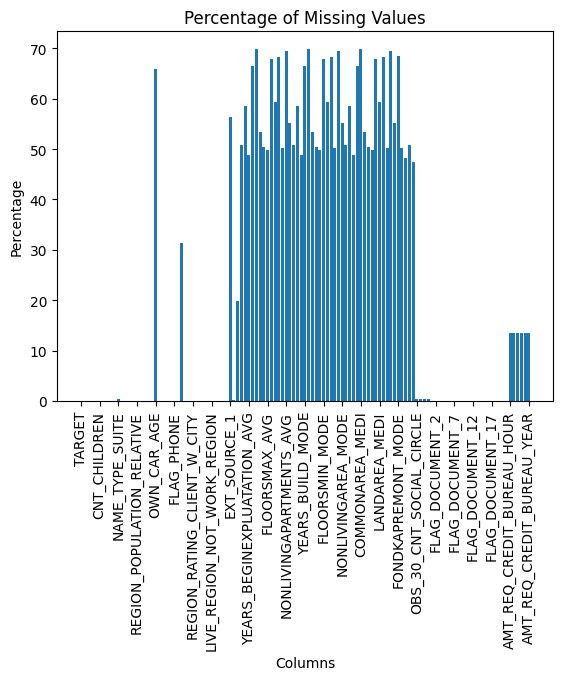

In [24]:
# Check percentage of nulls in each column
null_percentages = df.isnull().mean() * 100
# filter = null_percentages > 15

plt.bar(null_percentages.index, null_percentages.values)
plt.title('Percentage of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.xticks(range(0, len(null_percentages), 5))
plt.show()

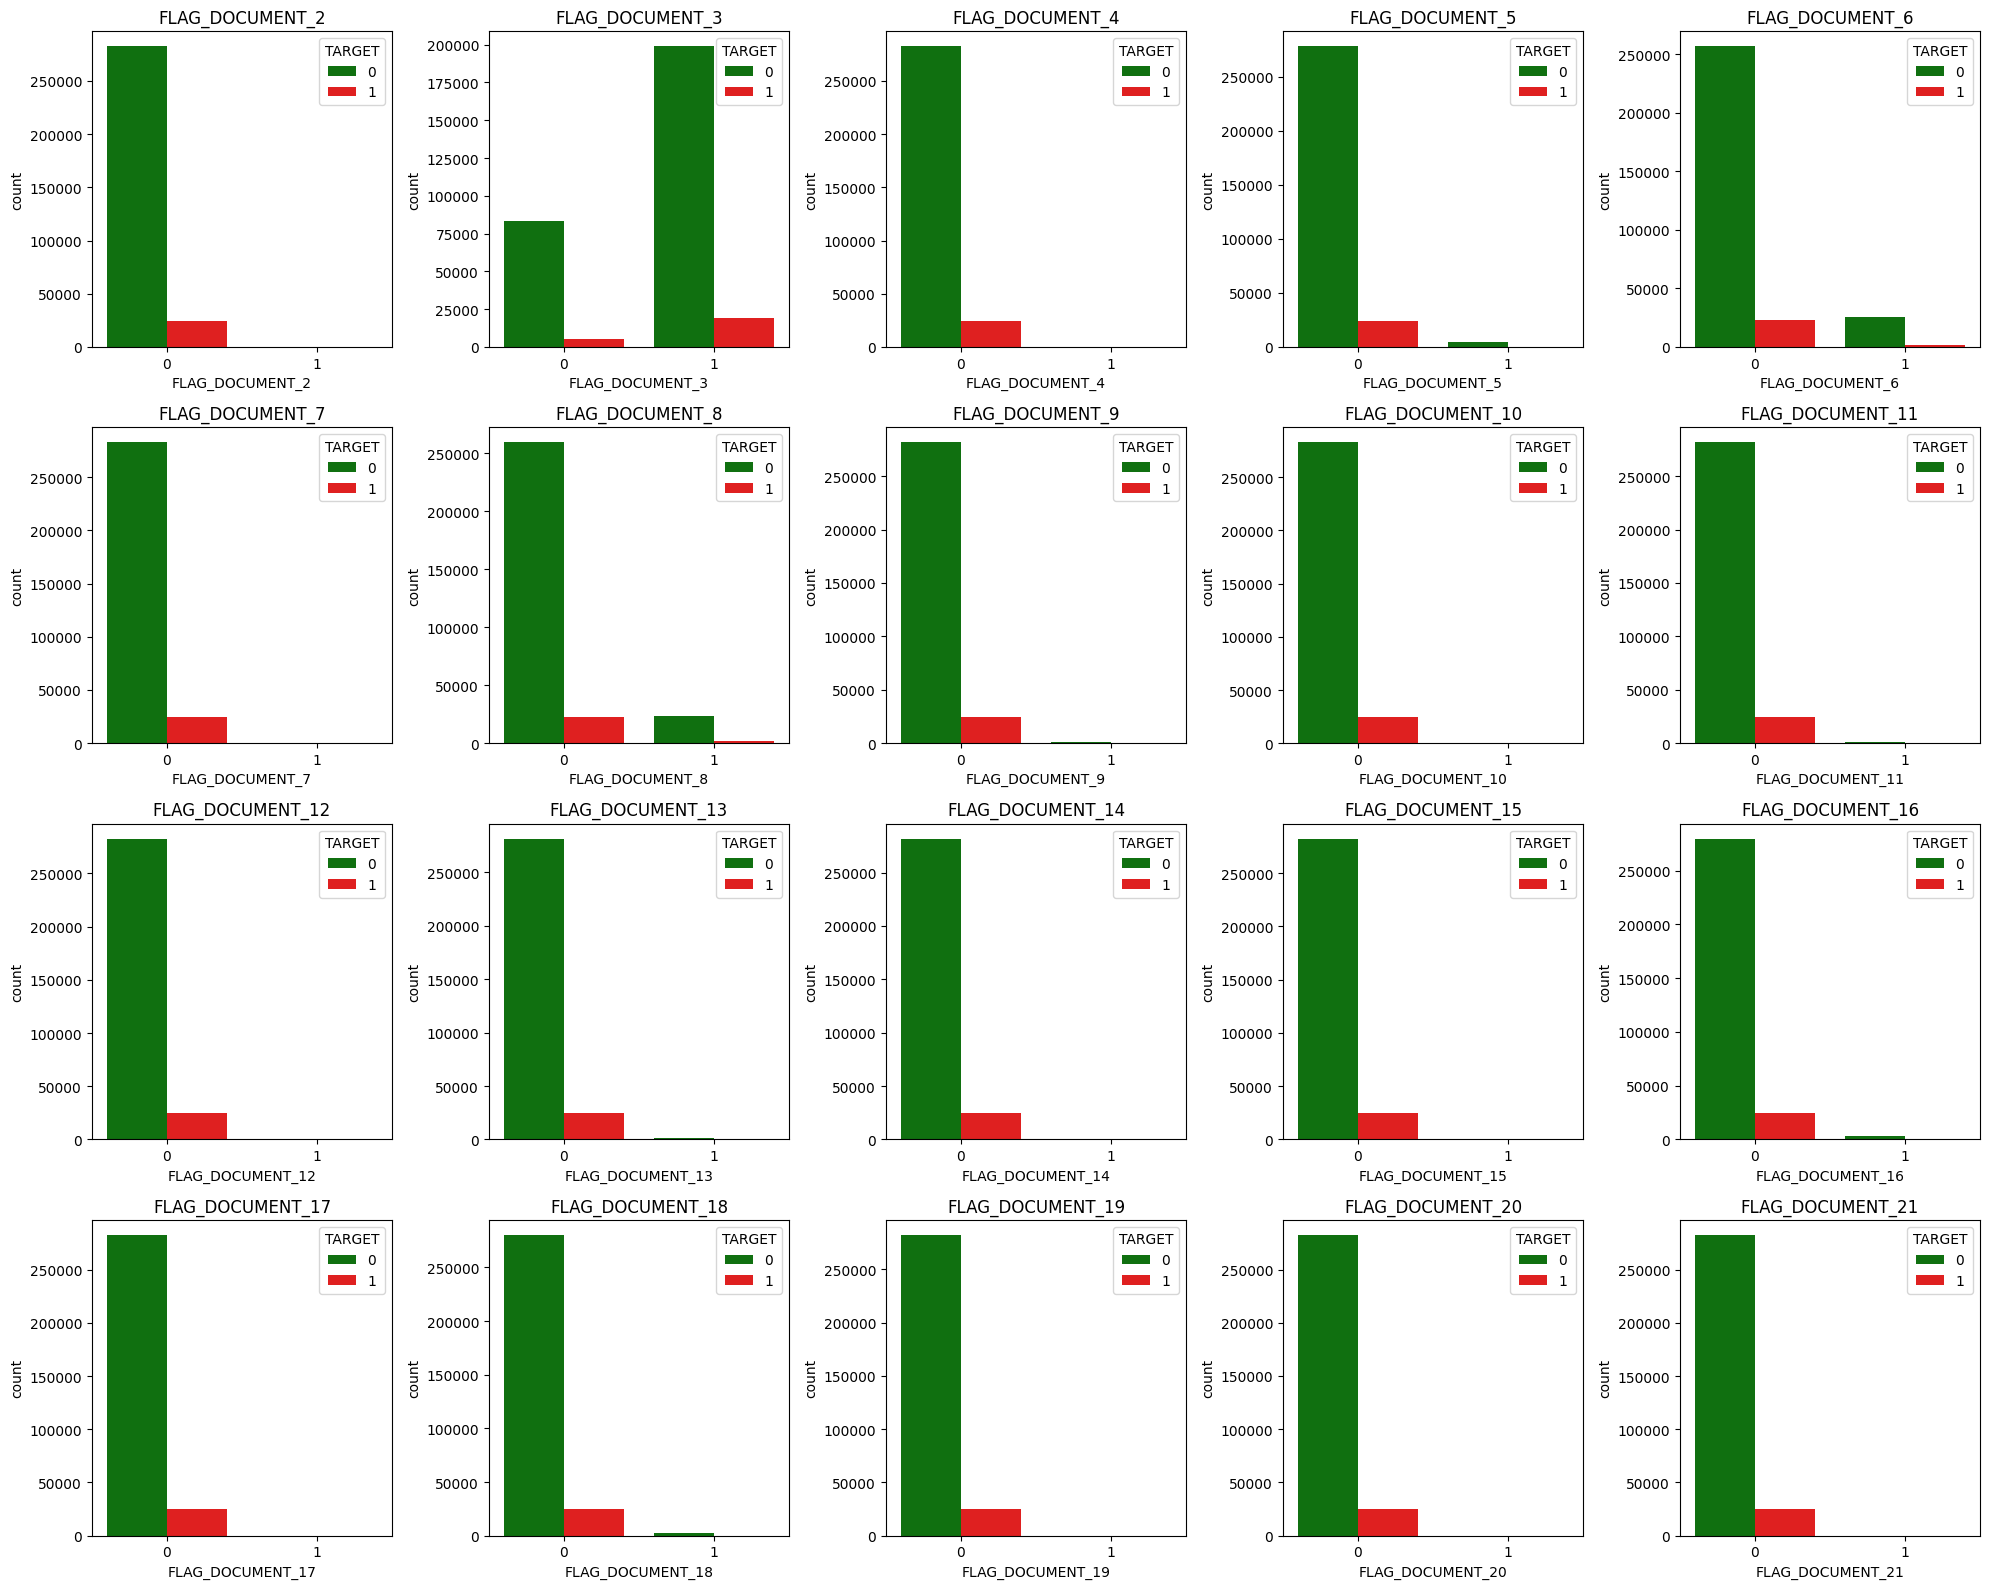

In [48]:
# Check if flag document columns will be useful

flag_doc_cols = [f'FLAG_DOCUMENT_{i}' for i in range(2, 22)]
flag_doc_df = df[flag_doc_cols + ['TARGET']]

# for col in flag_doc_cols:
#     plt.figure()
#     sns.countplot(data=flag_doc_df, x=col, hue='TARGET', palette=['g', 'r'])
    
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(flag_doc_cols):
    sns.countplot(data=flag_doc_df, x=col, hue='TARGET', palette=['g', 'r'], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()  

<Axes: >

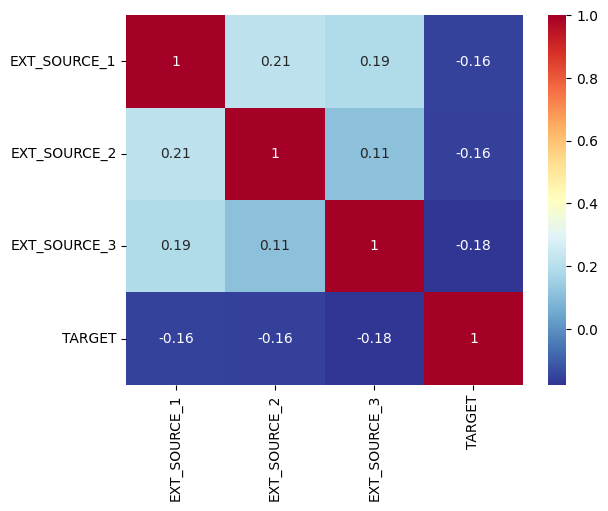

In [31]:
ext_source_df = df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','TARGET']]
ext_source_corr = ext_source_df.corr()

sns.heatmap(data=ext_source_corr, annot=True, cmap=plt.cm.RdYlBu_r)

<Axes: >

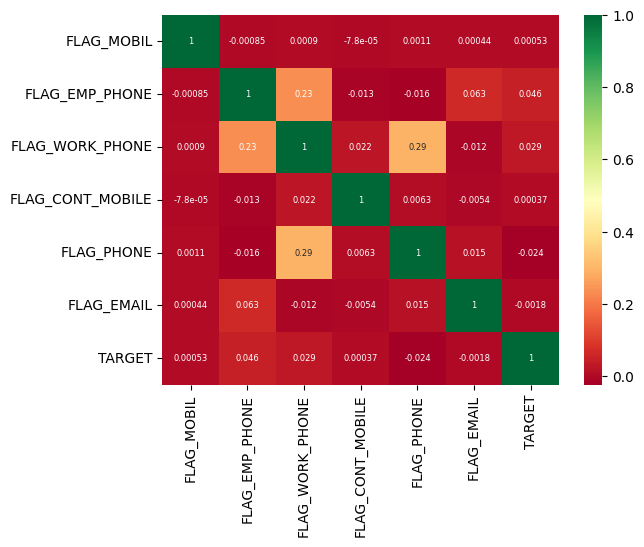

In [30]:
info_source_df = df[['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL','TARGET']]
info_source_corr = info_source_df.corr()

sns.heatmap(data=info_source_corr, annot=True, cmap='RdYlGn', annot_kws={"fontsize":6})

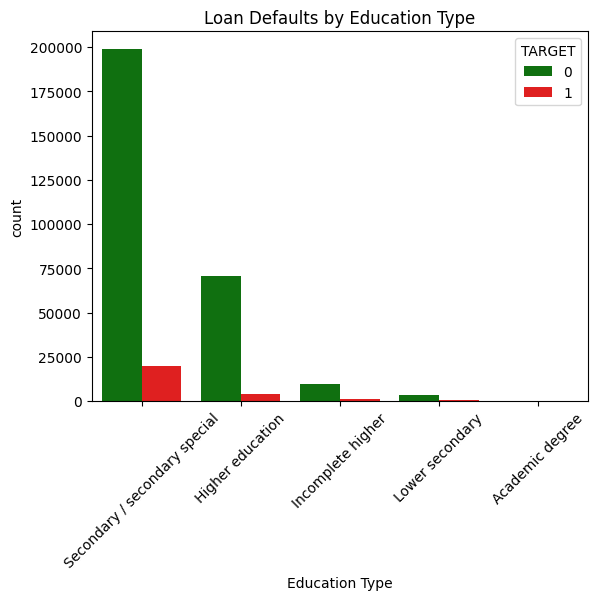

In [63]:
# Distribution over education
col = 'NAME_EDUCATION_TYPE'
sns.countplot(data=df, x=col, hue='TARGET', palette=['g', 'r'])
plt.title('Loan Defaults by Education Type')
plt.xlabel('Education Type')
plt.xticks(rotation=45)
plt.show() 

Text(0.5, 1.0, 'Loan Repaid by Gender (Target = 0)')

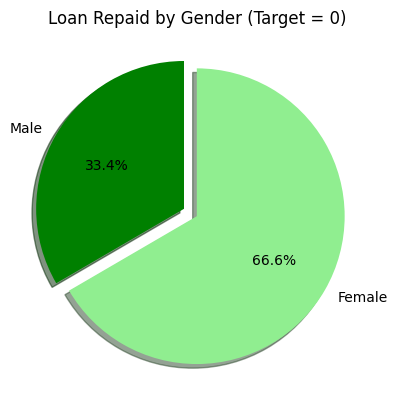

In [71]:
target_0 = df[df['TARGET'] == 0]
target_1 = df[df['TARGET'] == 1]

# create pie chart for target == 0
labels_0 = ['Male', 'Female']
sizes_0 = [target_0[target_0['CODE_GENDER'] == 'M'].shape[0], target_0[target_0['CODE_GENDER'] == 'F'].shape[0]]
colors_0 = ['green', 'lightgreen']
explode_0 = (0.1, 0)

plt.pie(sizes_0, labels=labels_0, colors=colors_0, explode=explode_0, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Loan Repaid by Gender (Target = 0)')

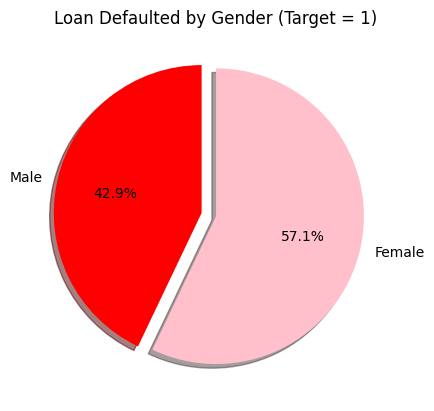

In [73]:
# create pie chart for target = 1
labels_1 = ['Male', 'Female']
sizes_1 = [target_1[target_1['CODE_GENDER'] == 'M'].shape[0], target_1[target_1['CODE_GENDER'] == 'F'].shape[0]]
colors_1 = ['red', 'pink']
explode_1 = (0.1, 0)

plt.pie(sizes_1, labels=labels_1, colors=colors_1, explode=explode_1, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Loan Defaulted by Gender (Target = 1)')

plt.show()

EDA on cleaned data

In [74]:
df = pd.read_csv("cleaned_data_ext_norm.csv", index_col=0)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,XNA
0,100002,1,1.0,1.0,1.0,1.0,0.001508,0.090287,0.090032,0.077441,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,1.0,0.0,1.0,0.0,0.002085,0.311736,0.132924,0.271605,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0.0,1.0,0.0,1.0,0.000354,0.022472,0.020025,0.023569,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,1.0,1.0,1.0,1.0,0.000816,0.116854,0.078975,0.117845,...,0,0,0,0,0,0,0,0,0,0
5,100008,0,1.0,1.0,1.0,1.0,0.000623,0.111235,0.101018,0.103255,...,0,0,0,0,0,0,0,0,0,0


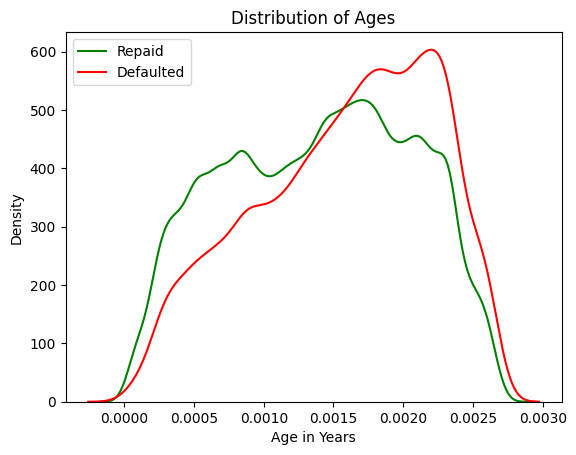

In [75]:
# Distribution over age
sns.kdeplot(df.loc[df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Repaid', color='green')
sns.kdeplot(df.loc[df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Defaulted', color='red')
plt.xlabel('Age in Years')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend(loc='upper left')
plt.show()

(array([244404.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  20490.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

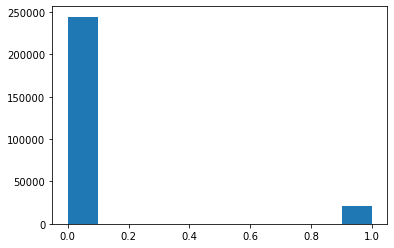

In [ ]:
plt.hist(df["TARGET"])

[Text(0.5, 1.0, 'Distribution of Class Labels')]

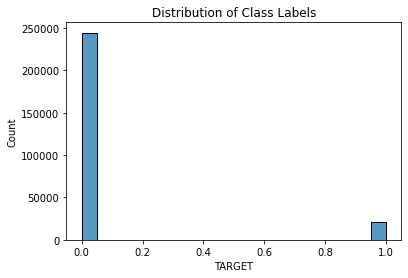

In [ ]:
sns.histplot(data=df, x="TARGET").set(title='Distribution of Class Labels')

In [ ]:
seed = 100
test_size = 0.15
X = df.drop(columns=["TARGET", "SK_ID_CURR"], axis=1)
y = df["TARGET"]

# note: stratify=df.buy generates
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

[Text(0.5, 1.0, 'Distribution of Training Class Labels')]

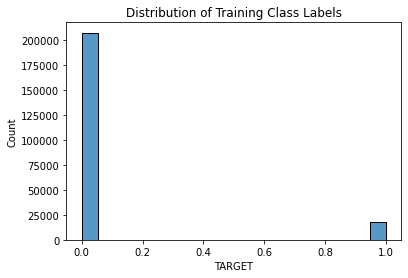

In [ ]:
sns.histplot(data=y_train).set(title='Distribution of Training Class Labels')

[Text(0.5, 1.0, 'Distribution of Testing Class Labels')]

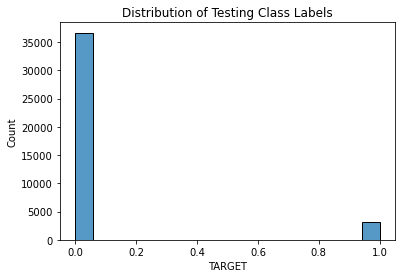

In [ ]:
sns.histplot(data=y_test).set(title='Distribution of Testing Class Labels')